# 오차역전파법

### 곱셈계층

In [34]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y

        return out

    def backward(self, dout):
        dx = dout * self.y # x와 y를 바꿔준다.
        dy = dout * self.x

        return dx, dy

In [35]:
apple = 100
apple_num = 2
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [36]:
# 역전파
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


### 덧셈계층

In [37]:
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [38]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# 역전파
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price)
print(dapple_num, dapple, dorange, dorange_num, dtax)

715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


## 활성화 함수 계층 구현하기

### ReLU 계층

In [39]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out
    
    def backward(self,dout):
        dout[self.mask] = 0
        dx = dout

        return dx

### Sigmoid 계층

In [40]:
import numpy as np

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

### Affine 계층

신경망의 순전파 때 수행하는 행렬의 곱은 기하학에서는 어파인 변환이라고 한다.

그래서 이 책에서는 어파인 변환을 수행하는 처리를 'Affine 계층' 이라는 이름으로 구현

In [41]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)

        return dx
    


### Softmax - with - Loss 계층

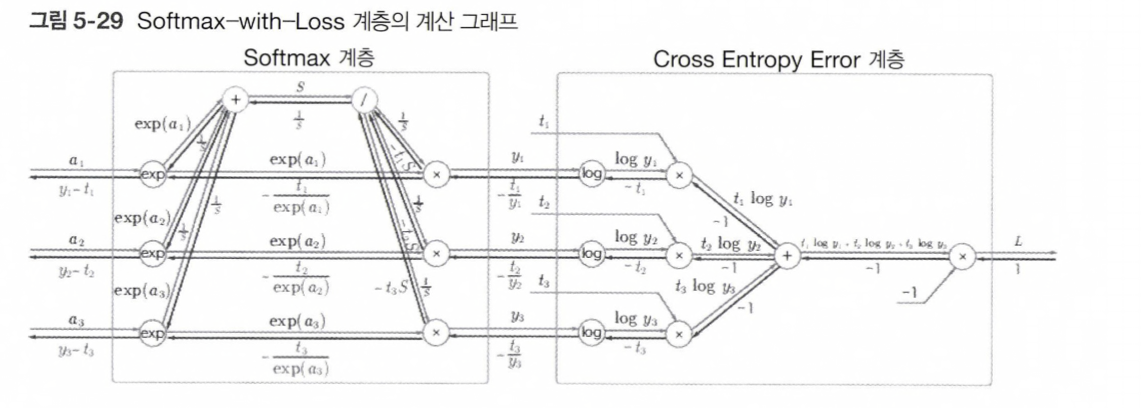

In [42]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)  
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.x = None

    def forward(self, x, t):
        self.t = t 
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss
    
    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

## 5.7 오차역전파법 구현하기

### 오차역전파법을 적용한 신경망 구현하기

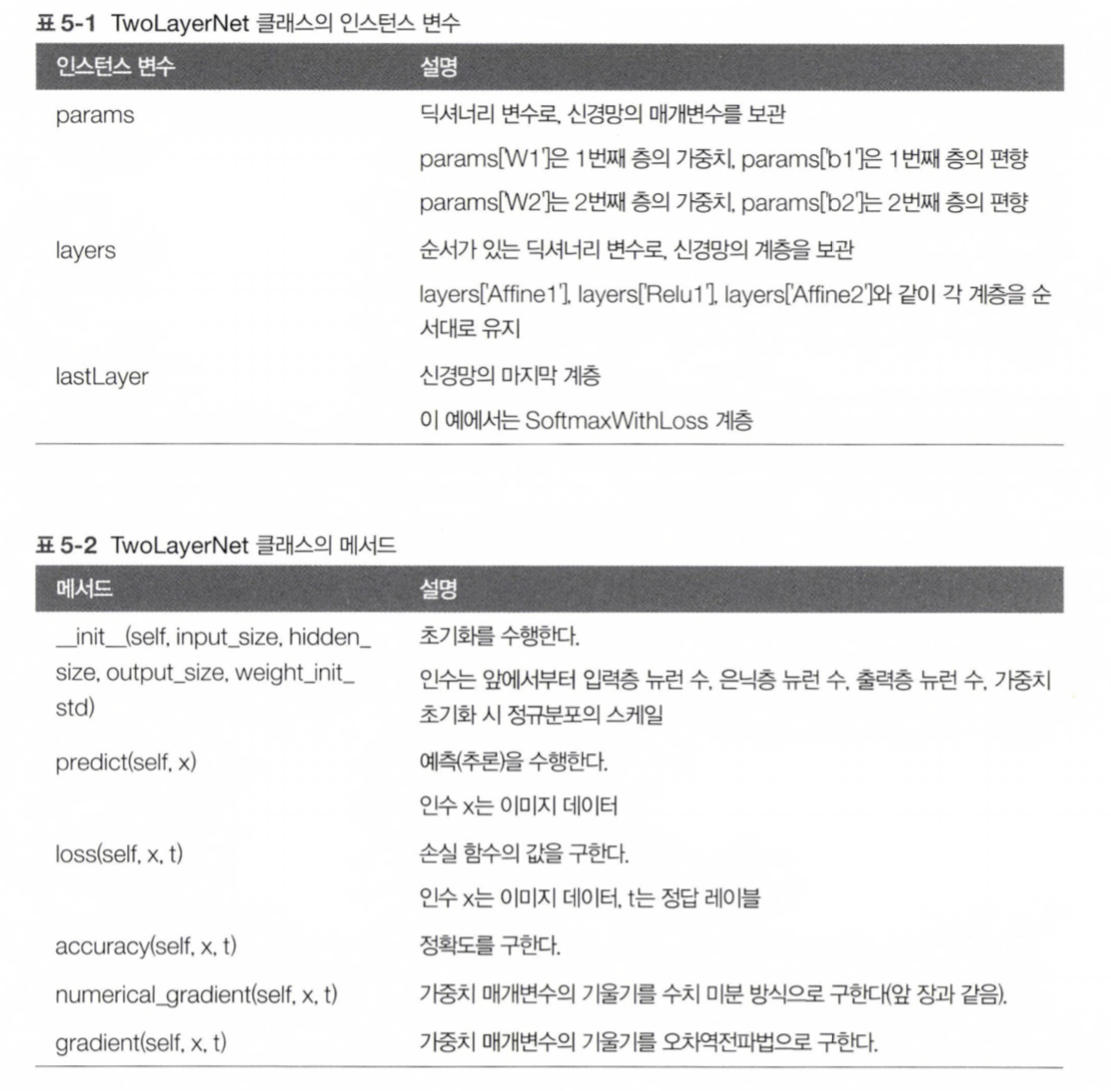

In [46]:
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        
        self.params['W2'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict() # 순서가 있는 딕셔너리 -> 층을 순서에 맞게 저장
        self.layers['Affine'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    # x: 입력 데이터, t: 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1: t = np.argmax(t, axis = 1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    # x: 입력 데이터, t: 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {} # grads 딕셔너리는 기울기를 저장하기 위한 공간
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

### 오차역전파법으로 구한 기울기 검증하기
수치미분의 결과와 오차역전파법의 결과를 비교해 오차역전파법을 제대로 구현했는지 검증하곤 함. 

이처럼 두 방식으로 구한 기울기가 일치암을 확인하는 작업 -> 기울기 확인

In [47]:
import numpy as np
from dataset.mnist import load_mnist
from two_layers_net import TwoLayerNet
(x_train, t_train), (x_test, t_test) =load_mnist(normalize = True, one_hot_label=True)

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 차이의 절댓값을 구한 후, 그 절대값들의 평균을 냄
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

W1:4.489254152797662e-10
b1:2.6499846405366073e-09
W2:5.934144285564996e-09
b2:1.40269881929167e-07


### 오차역전파법을 사용한 학습구현하기

In [49]:
import numpy as np
from dataset.mnist import load_mnist
from two_layers_net import TwoLayerNet
(x_train, t_train), (x_test, t_test) =load_mnist(normalize = True, one_hot_label=True)

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 역전파로 기울기를 구한다
    grad = network.gradient(x_batch, t_batch)

    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.12971666666666667 0.1282
0.90075 0.9029
0.9202 0.9236
0.93425 0.9337
0.9453666666666667 0.9442
0.9509833333333333 0.9498
0.9557 0.953
0.9601 0.9563
0.9637 0.9573
0.9643333333333334 0.9611
0.9689833333333333 0.9642
0.9711833333333333 0.9631
0.9730833333333333 0.9661
0.9753166666666667 0.9682
0.9752333333333333 0.9668
0.9772666666666666 0.9688
0.9789333333333333 0.9711
